# Data Import and Preprocessing
This notebook imports the data set collected as described in the paper. It further preprocesses the data (i.e., cleaning and extracting the blobs from a full capacitive image to achieve position-invariance).

In [1]:
import pandas as pd
import numpy as np

import time
import os  
import subprocess
from multiprocessing import Pool
import math

from IPython import display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle

import io
%matplotlib inline

## Importing data

In [2]:
df = ""
PATH = "./data/"

for filename in os.listdir(PATH):
    if filename.endswith(".txt"): 
        dfTemp = pd.read_csv(PATH + filename, header=None, names=["Participant", "Handedness", "Finger", "Task", "Ignore", "MatrixStr"], delimiter=";")
        if (type(df) is str):
            df = dfTemp
        else:
            df = df.append(dfTemp)
    else:
        continue
        
# Remove the "Ignore" column 
df = df.drop('Ignore', 1)

In [3]:
print("Number of samples:", len(df))

Number of samples: 921538


# Creating Data Structures 

In [4]:
%%time
temp_var = None
def transform_to_matrix(s):
    matrix = s.replace("\n", "")
    matrix = matrix.split(",")

    if (len(matrix) != 408):
        return -1, -1
    
    matrix = matrix[:407]
    
    # determine timestamp
    timestamp = str(matrix[0]) + str(matrix[1][:3])
    timestamp = int(timestamp)
    
    matrix = np.array(matrix[2:]).reshape(27, 15)
    
    matrix[matrix==''] = '0'
    matrix[matrix=='-'] = '0'
    
    try:
        matrix = matrix.astype(int)
    except ValueError:
        return -1, -1
    
    return matrix, timestamp

df['Matrix'] = df.MatrixStr.apply(lambda x : transform_to_matrix(x)[0])
df['Timestamp'] = df.MatrixStr.apply(lambda x : transform_to_matrix(x)[1])
df = df.drop(['MatrixStr'], axis=1)
df = df[~(df.Timestamp == -1)]

CPU times: user 8min 39s, sys: 11.6 s, total: 8min 51s
Wall time: 8min 30s


In [5]:
df = df[df.Task != "PAUSE"]

## Custom blob detection
The following code performs a blob detection to paste the touch blobs into blob images representing the touch on the upper left corner as described in the paper. This step is necessary to train a position-invariant model.

In [6]:
THRESHOLD = 30

# Recursive blob detection
def blob_detection(matrix, x, y, found):
    if x > 0 and x < len(matrix[0]) and y > 0 and y < len(matrix) and matrix[y][x] > THRESHOLD and ((x,y) not in found):
        found.append((x, y))
        blob_detection(matrix, x + 1, y, found) # right
        blob_detection(matrix, x - 1, y, found) # left
        blob_detection(matrix, x, y + 1, found) # top
        blob_detection(matrix, x, y - 1, found) # down
        
# Returns Blob Coordinates, connected tiles > 30
def get_blobs(matrix):
    blobs = []
    founds = []
    for y in range(0, len(matrix)):
        for x in range(0, len(matrix[0])):

            # blob detection
            found = []
            blob_detection(matrix, x, y, found)

            if (len(found) > 0):
                sorted_by_x = sorted(found, key=lambda x: x[0])
                sorted_by_y = sorted(found, key=lambda x: x[1])
                x_min = sorted_by_x[0][0]
                y_min = sorted_by_y[0][1]
                x_max = sorted_by_x[len(sorted_by_x) - 1][0]
                y_max = sorted_by_y[len(sorted_by_y) - 1][1]
                
                if (x_min - 1, x_max + 1, y_min - 1, y_max + 1) not in blobs and ((x_max - x_min) * (y_max - y_min)) > 1:
                    blobs.append((x_min - 1, x_max + 1, y_min - 1, y_max + 1))
                    founds.append(len(found))
    
    return blobs

# Returns the cutted blob
def get_blob_contents(matrix, blob_coordinates):
    matrices = []
    for c in blob_coordinates:
        matrices.append(matrix[c[2]:c[3], c[0]:c[1]])
    return matrices

# Returns the coordinates of the rectangle containing the touch blob
def get_plt_rect(blob_coordinates):
    return Rectangle((blob_coordinates[2] - 0.5, blob_coordinates[0]  - 0.5), (blob_coordinates[1] - blob_coordinates[0]) + 1, (blob_coordinates[3] - blob_coordinates[2]) + 1, fill=None, alpha=1, lw=2, color='lime')

In [7]:
%%time
df['BlobCoords'] = df.Matrix.apply(lambda x : get_blobs(x))
df['BlobCount'] = df.BlobCoords.apply(lambda x : len(x))
df['Blobs'] = [get_blob_contents(df.Matrix.iloc[i], df.BlobCoords.iloc[i]) for i in range(len(df))]

# remove all empty images and images with more than one blob
df = df[df.BlobCount == 1]

CPU times: user 13min 13s, sys: 3.3 s, total: 13min 16s
Wall time: 13min 16s


## Blob Image Generation

This generates a 405px images (for basic machine learning) and 27x15px images (for ConvNets).

In [8]:
def generate_blob_img(blobs):
    # taking the first blob as only one is expected
    blob = blobs[0]
    return np.pad(blob, ((0, 27 - blob.shape[0]),(0, 15 - blob.shape[1])), mode='constant', constant_values=0)

df['BlobImage'] = df.Blobs.apply(lambda x : generate_blob_img(x))

# Creating a flattened version of the blob image for basic ML approaches
df['BlobImgFlattened'] = df.BlobImage.apply(lambda x : x.flatten())

In [9]:
df.head()

,Participant,Handedness,Finger,Task,Matrix,Timestamp,BlobCoords,BlobCount,Blobs,BlobImage,BlobImgFlattened
42,20,left,ring,DRAG,"[[0, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0]...",1510664676885,"[(11, 15, 14, 18)]",1,"[[[2, 5, 14, 9], [1, 27, 113, 73], [4, 60, 217...","[[2, 5, 14, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[2, 5, 14, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
43,20,left,ring,DRAG,"[[0, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0]...",1510664676958,"[(10, 14, 14, 18)]",1,"[[[0, 4, 7, 5], [4, 9, 48, 44], [4, 40, 215, 1...","[[0, 4, 7, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[0, 4, 7, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
44,20,left,ring,DRAG,"[[0, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0]...",1510664677286,"[(9, 13, 15, 19)]",1,"[[[4, 5, 10, 5], [7, 27, 83, 48], [7, 83, 243,...","[[4, 5, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 5, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
45,20,left,ring,DRAG,"[[0, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0]...",1510664677988,"[(7, 11, 16, 20)]",1,"[[[4, 5, 11, 9], [4, 18, 62, 42], [2, 64, 232,...","[[4, 5, 11, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 5, 11, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
46,20,left,ring,DRAG,"[[0, 1, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0]...",1510664677169,"[(4, 8, 18, 22)]",1,"[[[4, 10, 18, 15], [5, 23, 125, 119], [7, 32, ...","[[4, 10, 18, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[4, 10, 18, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


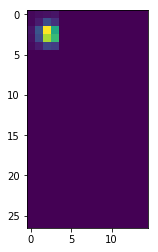

In [10]:
plt.imshow(df.BlobImage.iloc[20])

In [11]:
# Store data set
# df.to_pickle("full_data_set.pkl")